# Solving Differential equations in Julia

In this notebook I will go over some of the basics of solving ordinary differential equations (ODEs) numerically using ```julia```. I will demonstrate how to integrate differential equations using two approaches:

1. Solve using the functions in the julia package [```DifferentialEquations.jl```](http://docs.juliadiffeq.org/latest/).

2. Implement a solution method, like the [Euler method](https://en.wikipedia.org/wiki/Euler_method), in a DIY (Do It Yourself!) way.


To run this notebook you will need the following packages:

- To plot the results: ```Plots.jl``` and```PyPlot.jl```. Also ```LaTeXStrings.jl``` to be able to use LaTeX in the labels of the figures. 
- Labelled arrays (which  I explain later) ```LabelledArrays```.
- To use the differential equations functions ```DiffEqCallbacks.jl``` and ```DifferentialEquations.jl```



In [1]:
using Plots; pyplot();
using LaTeXStrings;
using BenchmarkTools;

To illustrate the two different solution approaches I will use the example of the [Lotka-Volterra](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) model.

#### Lotka-Volterra equations

The Lotka-Volterra equations are a simple mathematical model that it is used the predict the evolution of the population of 2 species which interact: one as preadator an the other one as prey. The mathematical model is a pair of first-order nonlinear differential equations for the variables $x$, and $y$ which stand for the population of preys and predators. The instantaneous rate of growth of each species is given by

\begin{equation}
    \begin{split}
        \frac{dx}{dt} &= x\;(\alpha - \beta y)
        \\
        \frac{dy}{dt} &= y\;(\gamma x - \delta)
    \end{split}
\end{equation}

$\alpha,\beta,\gamma,\delta$ are real positive parameters describing the interaction between both species (Their physical meaning is discussed [here](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)).

# Overview of the 2 methods

I will focus on ODEs systems of first degree, which have normally the form $\frac{d}{dt}X(t) = f(X(t),P,t)$, where $X(t) = \left( X_1(t),X_2(t),...,X_N(t)\right)^\mathsf{T}$ is the vector containing the $N$ independent variables, $P=\left( P_1,P_2,...,P_M\right)^\mathsf{T}$ is a vector containing all $M$ parameters the problem depends on, and $t$ is time. $f(X(t),P,t)$ is an $N$-dimensional vector function that gives the evoliution of the components of $X$, $\frac{d}{dt}X_i(t) = f_i(X(t),P,t)$. This kind of system is pretty general, because even if we have a system of equations of higher degree we can alaways reduce it to first degree.

In the model we are using we have $X(t) = \left( x(t),y(t) \right)^\mathsf{T}$, $P =\left( \alpha,\beta,\gamma,\delta \right)^\mathsf{T}$ and 

\begin{equation}
    f(X,P,t) = 
    \Bigg(
    \begin{array}{c}
        x\;(\alpha - \beta y)
        \\
        y\;(\gamma x - \delta)
    \end{array}
    \Bigg)
\end{equation}

#### Solution with ```DifferentialEquations.jl```

The work-flow with this package consists in first defining a ```ODEProblem``` object from the initial conditions and the function  $f(X(t),P,t)$. Then, one calls the solve function to integrate the equation for the given times. 

#### Solution with DIY solver

In this section I consider the [Euler method](https://en.wikipedia.org/wiki/Euler_method) for its simplicity, the same philosophy can be applied to other methods.

The Euler method consists in discretizing the time variable in small intervals 

```pseudocode
x_[i+1] = x_[i] + f(x_[i]),P,t_[i]) * (t_[i+1]-t_[i])
```


# Solution with ```DifferentialEquations.jl```

Now, the steps to solve the equation

#### 1. Import the necessary packages

In [2]:
using DifferentialEquations;
using LabelledArrays;

#### 2. Defining the $f(X(t),P,t)$ function

This can be done the two different forms. We can either define a function that returns the value of the derivative

In [3]:
function f_LV(X,P,t)
    return [
            X[1] * (P.α - P.β * X[2]),
            -X[2] * (P.γ - P.δ * X[1])
    ];
end;

or defining a function that changes the values of a preallocated array ```dX``` which contains the derivatives of the dependent variables.

In [4]:
function f_LV!(dX,X,P,t)
    dX[1] = X[1] * (P.α - P.β * X[2]);
    dX[2] = -X[2] * (P.γ - P.δ * X[1]);
end;

The latter kind of function (the ones that change the state if its arguments) is known as a **mutating function** in julia. It is more efficient to define the derivative with a mutating function since changing the values of already allocated arrays is faster than allocating new arrays. Allocating memory for arrays is expensive when done repeatedly. See the results of the folowing performance test of both functions. 

In [5]:
dX = rand(2);
X = rand(2);
P = LVector(α =4. , β=1. , γ = 4. , δ = 1.);
t = 0.;

Test ```f_LV```

In [6]:
@benchmark f_LV(X,P,t)

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  1
  --------------
  minimum time:     39.630 ns (0.00% GC)
  median time:      42.193 ns (0.00% GC)
  mean time:        49.140 ns (11.47% GC)
  maximum time:     3.157 μs (98.19% GC)
  --------------
  samples:          10000
  evals/sample:     991

Test ```f_LV!``` 

In [7]:
@benchmark f_LV!(dX,X,P,t)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     22.970 ns (0.00% GC)
  median time:      23.817 ns (0.00% GC)
  mean time:        24.785 ns (2.08% GC)
  maximum time:     1.806 μs (98.62% GC)
  --------------
  samples:          10000
  evals/sample:     996

Comparing the results of both tests we see that the mutating function consumes less resources (memory) and is almost twices as fast. When doing benchmarks, is usually more informative to check the median time since is less biased by the outliers in the sample, i.e., exceptionally large or small times

#### 3. Defining the problem object

Here, we will defined what is called a ```ODEProblem``` *object*, which contains all the relevant information of our problem. The basic pieces we need to construct the problem are

- The function $f(dX,X,P,t)$ that update the value of the derivative with respect time.
- The initial conditions
- The time span
- The parameters


**Initial condition**

In [8]:
u0_LV = [1.,1.]

2-element Array{Float64,1}:
 1.0
 1.0

**Time span**

In [46]:
T_Final_LV = 5.              #Final time
tspan_LV = (0.0,T_Final_LV);  #From 0 to T_Final_LV

**Parameters**

They are put inside a [Labelled vector](https://github.com/JuliaDiffEq/LabelledArrays.jl). This kind of arrays allow accesing to the elements by their name ```LabelledarrayName.elementName```.

In [47]:
P_LV = LVector(α =4. , β=1. , γ = 4. , δ = 1.);

println(P_LV.α,)

4.0


**Construct the problem object**

In [48]:
problem_LV = ODEProblem(f_LV!,u0_LV,tspan_LV,P_LV)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: [1.0, 1.0]

#### 4. Solve the problem by calling the function ```solve``` from the DifferentialEquations Package.

Store the solution in the array sol_LV

In [49]:
sol_LV = solve(problem_LV)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 37-element Array{Float64,1}:
 0.0                
 0.06084855858191972
 0.17081664347724562
 0.28690035693517885
 0.4295177475208707 
 0.6053539350149165 
 0.7725940620742761 
 0.8921014499734694 
 0.9949721204630707 
 1.103132779271137  
 1.198319187050117  
 1.2924131485440091 
 1.4268754445976708 
 ⋮                  
 3.3406991906557018 
 3.452284762512834  
 3.601892162283956  
 3.7823900973442677 
 3.967856971804779  
 4.184397848629477  
 4.38565144861372   
 4.634068840807569  
 4.7329161278233896 
 4.836797368361293  
 4.961287566259115  
 5.0                
u: 37-element Array{Array{Float64,1},1}:
 [1.0, 1.0]                              
 [1.2064374465005956, 0.8381853116209412]
 [1.7290117538796257, 0.633178941979179] 
 [2.576362455225402, 0.5091573843408783] 
 [4.258353286776334, 0.46377496247594024]
 [7.849430636440425, 0.6461910344584615] 
 [12.81411583846938, 1.8518760412004496] 
 [13.6279729819

#### 5. Using the solution

There are several ways of accessing the data of the solution. 

##### Array interface
with ```sol_LV[i]``` it is possible to access the values of the components of the solutio at the time step ```i```:

In [68]:
sol_LV[1]

2-element Array{Float64,1}:
 1.0
 1.0

with ```sol_LV[i,j]``` it is possible to access ```i```th- component of the solution at the time step ```j``` 

In [71]:
sol_LV[2,4]

0.5091573843408783

the time value at step ```i``` can be accesed with ```sol_LV.t[i]```

In [73]:
sol_LV.t[10]

1.103132779271137

##### Interpolations

By default, the solve function returns time values and solution at a discrete set of time steps but also an interpolation. The command ```sol_LV(t)``` computes an interpolation of the solution at time value ```t```.

In [81]:
sol_LV(3.7)

2-element Array{Float64,1}:
 0.694459093055291 
 1.5438272102468726

with ```sol_LV(t,idxs=i)``` we only interpolate the ```i```-th component of the solution

In [82]:
sol_LV(3.7,idxs=2)

1.5438272102468726

#### 6. Plot the solutions

The plots package has a recipe that automatically plots ODEProblem solution objects

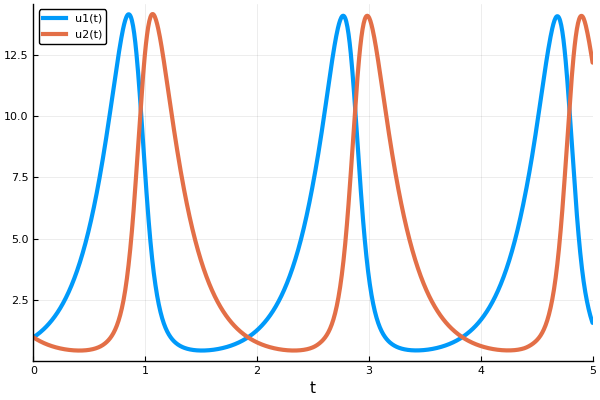

In [103]:
plot(sol_LV)

The last kind of plot is only useful to previsualize the results, to do more ellaborate plots it is necessary to plot manually. For example: Phase-space plot with stream arrows.

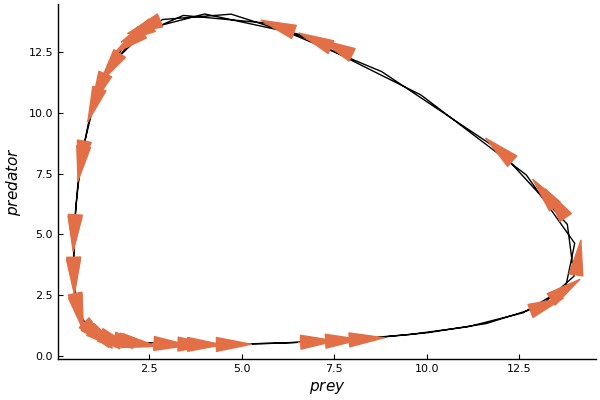

In [253]:
plotPhase_LV = plot(
    grid = false
    ,legend = false
    ,xlabel = latexstring("prey")
    ,ylabel = latexstring("predator")
)

plotΔt_LV = 0.05;
t = collect(1:plotΔt_LV:T_Final_LV)


plot!(
        sol_LV.(t,idxs=1), sol_LV.(t,idxs=2)
        ,color=:black
    )

y = [zeros(length(sol_LV)),zeros(length(sol_LV))]
for ii in eachindex(sol_LV)
    y[1][ii],y[2][ii] = f_LV(sol_LV[ii],P_LV,sol_LV.t[ii])
    norm = sqrt(y[1][ii]^2+y[2][ii]^2)
    y[1][ii],y[2][ii] = y[1][ii]/norm,y[2][ii]/norm
    
end

quiver!(sol_LV[1,:],sol_LV[2,:],quiver=1. .*(y[1],y[2]),arrows=(2.5,1.))

plotPhase_LV

# Solution with DIY solver

#### 1. Define a function that updates the value of the solution

In [282]:
function step!(X_new,X_old,P,t,Δt)
    X_new .= X_old + Δt .* f_LV(X_old,P,t)
end

step! (generic function with 1 method)

#### 2. Define the initial condition

In [283]:
u0_LV = [1.,1.]

2-element Array{Float64,1}:
 1.0
 1.0

#### 3. Time vector

In [289]:
Δt = 0.005
T_Final_LV = 3.

t_ = collect(0:Δt:T_Final_LV)

N_steps = length(t_)-1 #number of steps

600

#### 4. Initalize the solution array

In [290]:
X = [zeros(2) for ii in eachindex(t_)];
X[1].=u0_LV

2-element Array{Float64,1}:
 1.0
 1.0

#### 5. Solution loop

In [291]:
for ii in 1:N_steps
    step!(X[ii+1],X[ii],P_LV,t_[ii],Δt)
end

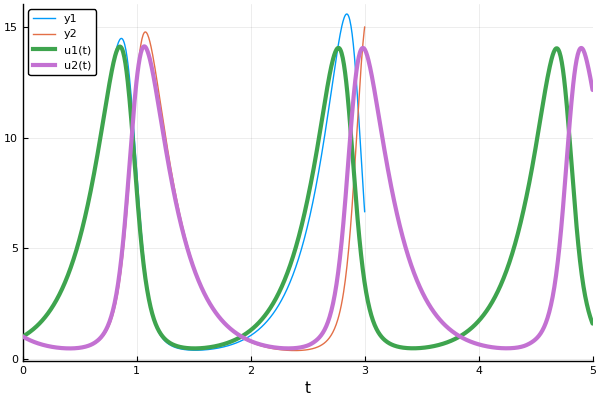

In [294]:
plot(t_,[X[ii][1] for ii in eachindex(X)])
plot!(t_,[X[ii][2] for ii in eachindex(X)])

#Compare with DifferentialEquations.jl
plot!(sol_LV)

The solutions are consistent for low values of time. However they start to diverge as time increases. This can be due to the fact that the integration time step in the DIY solution is fixed, which in this particular problem seems problematic. The DifferentialEquations package gives you the values of the solution at the time values you specify in the solve call but it uses intermediate points to integrate the differential equation and variable dt if needed.